In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/amazon-fine-food-reviews/hashes.txt
/kaggle/input/amazon-fine-food-reviews/Reviews.csv
/kaggle/input/amazon-fine-food-reviews/database.sqlite
/kaggle/input/glove-6b-100-d/glove.6B.100d.txt


In [2]:
import pandas as pd

In [3]:
dataset=pd.read_csv(r"/kaggle/input/amazon-fine-food-reviews/Reviews.csv")

In [4]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 568454 entries, 0 to 568453
Data columns (total 10 columns):
 #   Column                  Non-Null Count   Dtype 
---  ------                  --------------   ----- 
 0   Id                      568454 non-null  int64 
 1   ProductId               568454 non-null  object
 2   UserId                  568454 non-null  object
 3   ProfileName             568428 non-null  object
 4   HelpfulnessNumerator    568454 non-null  int64 
 5   HelpfulnessDenominator  568454 non-null  int64 
 6   Score                   568454 non-null  int64 
 7   Time                    568454 non-null  int64 
 8   Summary                 568427 non-null  object
 9   Text                    568454 non-null  object
dtypes: int64(5), object(5)
memory usage: 43.4+ MB


In [5]:
dataset.head(5)

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


In [6]:
print(dataset[['Score','Text']].head(5))

   Score                                               Text
0      5  I have bought several of the Vitality canned d...
1      1  Product arrived labeled as Jumbo Salted Peanut...
2      4  This is a confection that has been around a fe...
3      2  If you are looking for the secret ingredient i...
4      5  Great taffy at a great price.  There was a wid...


In [7]:
print(dataset.isna().sum())

Id                         0
ProductId                  0
UserId                     0
ProfileName               26
HelpfulnessNumerator       0
HelpfulnessDenominator     0
Score                      0
Time                       0
Summary                   27
Text                       0
dtype: int64


In [8]:
lmtpData=dataset[['Text','Summary','Score']].sample(n=1000)
print(lmtpData)

                                                     Text  \
348641  Great taste, crunch and my kids enjoy it. It d...   
440075  I like the flavor of this brand. It has taken ...   
189500  I used the coconut oil to moisturize my skin a...   
215092  My son loves his Happy Baby pouches, and I lik...   
41745   The product has served the purpose for which i...   
...                                                   ...   
39439   Many of these exploded making a huge mess with...   
248222  One of the finest coffees I've ever drank. Ful...   
528304  These are surprisingly good considering how mu...   
410714  Todays SPAM is not the SPAM of years ago.  The...   
22379   These pretzels are just the best! The whole gr...   

                                 Summary  Score  
348641                   Healthier Snack      4  
440075                     I like these!      4  
189500                       Coconut Oil      4  
215092          Delicious for Moms, too!      5  
41745            

### ADDING SENTIMENT COLUMN

In [9]:
#0-negative, 1-positive
def lblScore(score):
    if score<=2:
        return 0
    elif score>=4:
        return 1
    else:
        return 2
lmtpData['Sentiment']=lmtpData['Score'].apply(lblScore)
lmtpData.head(5)

,Text,Summary,Score,Sentiment
348641,"Great taste, crunch and my kids enjoy it. It d...",Healthier Snack,4,1
440075,I like the flavor of this brand. It has taken ...,I like these!,4,1
189500,I used the coconut oil to moisturize my skin a...,Coconut Oil,4,1
215092,"My son loves his Happy Baby pouches, and I lik...","Delicious for Moms, too!",5,1
41745,The product has served the purpose for which i...,pill pockets,5,1


In [10]:
lmtpData['Sentiment'].value_counts()

Sentiment
1    767
0    151
2     82
Name: count, dtype: int64

#### VECTORS

In [11]:
import numpy as np

glove_path = "/kaggle/input/glove-6b-100-d/glove.6B.100d.txt"

def loadGloveEmbeddings(filePath, embedding_dim=100):
    embeddingsIndex = {}
    with open(filePath, encoding="utf8") as f:
        for line in f:
            values = line.split()
            word = values[0]
            coefs = np.asarray(values[1:], dtype='float32')
            embeddingsIndex[word] = coefs
    return embeddingsIndex

gloveEmbeddings = loadGloveEmbeddings(glove_path)
print("Loaded {} word vectors.".format(len(gloveEmbeddings)))


        

Loaded 400000 word vectors.


#### CREATING EMBEDDING MATRIX

In [12]:
lmtpData['Summary']=lmtpData['Summary'].fillna("")
lmtpData['CombinedText']=lmtpData['Summary'] + " " + lmtpData['Text']


In [13]:
#tokenizing
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

tokenizer=Tokenizer()
tokenizer.fit_on_texts(lmtpData['CombinedText'])
sequences=tokenizer.texts_to_sequences(lmtpData['CombinedText'])

maxLen=100
padded_sequences=pad_sequences(sequences,maxlen=maxLen,padding='post')

In [14]:
embedding_dim=100
vocabSize=len(tokenizer.word_index) + 1

embeddingMatrix=np.zeros((vocabSize,embedding_dim))

for word,i in tokenizer.word_index.items():
    embeddingVector=gloveEmbeddings.get(word)
    if embeddingVector is not None:
        embeddingMatrix[i]=embeddingVector

In [15]:
print("Embedding matrix shape:", embeddingMatrix.shape)


Embedding matrix shape: (7089, 100)


### MAKING THE MODEL

In [16]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout,Input
maxLen=100
X_train = padded_sequences 
y_train = lmtpData["Sentiment"].values  

print("Padded shape:", X_train.shape)  
print("Labels shape:", y_train.shape) 

model = Sequential([
    Input(shape=(maxLen,)),
    Embedding(input_dim=vocabSize,  
              output_dim=embedding_dim, 
              weights=embeddingMatrix, 
             
              trainable=False), 
    LSTM(128, return_sequences=True),
    LSTM(64),
    Dropout(0.3),
    Dense(3, activation='softmax') 
])


model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

model.summary()


Padded shape: (1000, 100)
Labels shape: (1000,)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ (None, 100, 100)            │         708,900 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm (LSTM)                          │ (None, 100, 128)            │         117,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 64)                  │          49,408 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 3)                   │             195 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 875,751 (3.34 MB)

 Trainable params: 166,851 (651.76 KB)

 Non-trainable params: 708,900 (2.70 MB)

In [17]:

history=model.fit(X_train, y_train, epochs=10, batch_size=32, validation_split=0.3)



Epoch 1/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 6s 153ms/step - accuracy: 0.6950 - loss: 0.9186 - val_accuracy: 0.7800 - val_loss: 0.6753
Epoch 2/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 3s 137ms/step - accuracy: 0.7571 - loss: 0.7143 - val_accuracy: 0.7800 - val_loss: 0.6836
Epoch 3/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 3s 143ms/step - accuracy: 0.7619 - loss: 0.7127 - val_accuracy: 0.7800 - val_loss: 0.6755
Epoch 4/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 3s 138ms/step - accuracy: 0.7675 - loss: 0.7102 - val_accuracy: 0.7800 - val_loss: 0.6761
Epoch 5/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 3s 137ms/step - accuracy: 0.7752 - loss: 0.6837 - val_accuracy: 0.7800 - val_loss: 0.6771
Epoch 6/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 3s 134ms/step - accuracy: 0.7754 - loss: 0.6849 - val_accuracy: 0.7800 - val_loss: 0.6784
Epoch 7/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 3s 135ms/step - accuracy: 0.7640 - loss: 0.6758 - val_accuracy: 0.7800 - val_loss: 0.6756
Epoch 8/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 3s 137ms/step - accuracy: 0.7511 - loss: 0.7062 - val_accuracy: 0.

#### PLOTTING AND ACCURACY AND LOSS CURVES

In [18]:
import matplotlib.pyplot as plt
accuracy=history.history['accuracy']
valAccuracy=history.history['val_accuracy']
loss = history.history['loss']
valLoss = history.history['val_loss']
epochs_range = range(1, len(accuracy) + 1)

Text(0.5, 1.0, 'Training & Validation Accuracy')

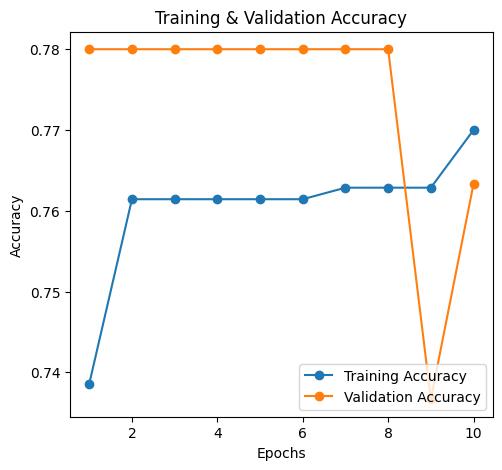

In [19]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, accuracy, label='Training Accuracy', marker='o')
plt.plot(epochs_range, valAccuracy, label='Validation Accuracy', marker='o')
plt.legend(loc='lower right')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training & Validation Accuracy')

Text(0.5, 1.0, 'Training & Validation Loss')

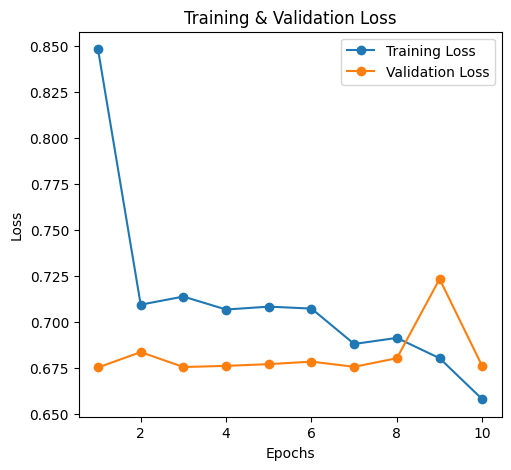

In [20]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss', marker='o')
plt.plot(epochs_range, valLoss, label='Validation Loss', marker='o')
plt.legend(loc='upper right')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training & Validation Loss')

##### overfitting

### OUTPUT VS PREDICTED OUTPUT


In [21]:
predictions=model.predict(padded_sequences)
predictedClasses=np.argmax(predictions,axis=1)

32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 53ms/step


In [22]:
comparisonData=pd.DataFrame({
    "Text":lmtpData["CombinedText"],
    "Actual Sentiment":lmtpData["Sentiment"].values,
    "Predicted Sentiment":predictedClasses
})
comparisonData.head(10)

,Text,Actual Sentiment,Predicted Sentiment
348641,"Healthier Snack Great taste, crunch and my kid...",1,1
440075,I like these! I like the flavor of this brand....,1,1
189500,Coconut Oil I used the coconut oil to moisturi...,1,1
215092,"Delicious for Moms, too! My son loves his Happ...",1,1
41745,pill pockets The product has served the purpos...,1,1
184135,Guaranteed yum! I've purchased both the Pro-Tr...,1,1
288126,yummy & a great price This tomato paste is del...,1,1
199508,Yay! Flake Bars on Amazon! I was SO happy to s...,1,1
494955,DELICIOUS Great maple syrup for the maple syru...,1,1
514305,My cats love this stuff My cats seem to love a...,1,1


In [23]:
comparisonData.head(20)

,Text,Actual Sentiment,Predicted Sentiment
348641,"Healthier Snack Great taste, crunch and my kid...",1,1
440075,I like these! I like the flavor of this brand....,1,1
189500,Coconut Oil I used the coconut oil to moisturi...,1,1
215092,"Delicious for Moms, too! My son loves his Happ...",1,1
41745,pill pockets The product has served the purpos...,1,1
184135,Guaranteed yum! I've purchased both the Pro-Tr...,1,1
288126,yummy & a great price This tomato paste is del...,1,1
199508,Yay! Flake Bars on Amazon! I was SO happy to s...,1,1
494955,DELICIOUS Great maple syrup for the maple syru...,1,1
514305,My cats love this stuff My cats seem to love a...,1,1


## TRAINING USING NEW SAMPLE DATASET

In [24]:
droppedData=dataset.drop(lmtpData.index)
dataset2=droppedData.sample(1000,random_state=43)
dataset2.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
150198,150199,B001SB3WZU,A1P2XYD265YE21,"Andrea ""Readaholic""",6,6,5,1243641600,Amazing Cherry Pie,Before I sing the praises for this wonderful p...
541147,541148,B000FMTJJQ,A2OEZOQZLR76X5,Sarah,0,2,5,1184284800,delicious!,Madhava Agave Nectar has a suprisingly mild fl...
480347,480348,B000DZDJ0K,A132ETQPMHQ585,"Donna's Reviews ""I Love Shopping on Amazon!""",0,0,5,1324252800,Love this stuff........,Love this stuff........Pamela's Products Ultim...
363030,363031,B0049WV8S8,A1YGZKEUNNJB6C,karenk,1,1,5,1335312000,So wonderful that I bought a second one!,"Perfect, perfect, perfect. What a little gem ..."
555895,555896,B004E7A33E,A1OXWH79Y58DB5,flipflop,2,4,2,1320796800,Main ingredient says natural blueberry flavor,I love Olive Nation's Strawberry extract; howe...


In [25]:
lmtpData2=dataset2[['Score','Summary','Text']]
lmtpData2.head()

,Score,Summary,Text
150198,5,Amazing Cherry Pie,Before I sing the praises for this wonderful p...
541147,5,delicious!,Madhava Agave Nectar has a suprisingly mild fl...
480347,5,Love this stuff........,Love this stuff........Pamela's Products Ultim...
363030,5,So wonderful that I bought a second one!,"Perfect, perfect, perfect. What a little gem ..."
555895,2,Main ingredient says natural blueberry flavor,I love Olive Nation's Strawberry extract; howe...


In [26]:
lmtpData2 = lmtpData2.copy()
lmtpData2['Summary'] = lmtpData2['Summary'].fillna("")
lmtpData2['CombinedText'] = lmtpData2['Summary'] + " " + lmtpData2['Text']


In [27]:
lmtpData2.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1000 entries, 150198 to 28985
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Score         1000 non-null   int64 
 1   Summary       1000 non-null   object
 2   Text          1000 non-null   object
 3   CombinedText  1000 non-null   object
dtypes: int64(1), object(3)
memory usage: 39.1+ KB


In [28]:

lmtpData2['Sentiment']=lmtpData2['Score'].apply(lblScore)
lmtpData2.head(5)

,Score,Summary,Text,CombinedText,Sentiment
150198,5,Amazing Cherry Pie,Before I sing the praises for this wonderful p...,Amazing Cherry Pie Before I sing the praises f...,1
541147,5,delicious!,Madhava Agave Nectar has a suprisingly mild fl...,delicious! Madhava Agave Nectar has a suprisin...,1
480347,5,Love this stuff........,Love this stuff........Pamela's Products Ultim...,Love this stuff........ Love this stuff..........,1
363030,5,So wonderful that I bought a second one!,"Perfect, perfect, perfect. What a little gem ...",So wonderful that I bought a second one! Perfe...,1
555895,2,Main ingredient says natural blueberry flavor,I love Olive Nation's Strawberry extract; howe...,Main ingredient says natural blueberry flavor ...,0


In [29]:
tokenizer.fit_on_texts(lmtpData2['CombinedText'])
sequences=tokenizer.texts_to_sequences(lmtpData2['CombinedText'])

maxLen=100
paddedData=pad_sequences(sequences,maxlen=maxLen,padding='post')
embedding_dim=100
vocabSize=len(tokenizer.word_index) + 1

embeddingMatrix2=np.zeros((vocabSize,embedding_dim))

for word,i in tokenizer.word_index.items():
    embeddingVector2=gloveEmbeddings.get(word)
    if embeddingVector2 is not None:
        embeddingMatrix2[i]=embeddingVector2

### BALANCING THE CLASSES

In [30]:
from imblearn.over_sampling import SMOTE


y2 = lmtpData2['Sentiment'].values


smote = SMOTE(random_state=42)
X_resampled, Y_resampled = smote.fit_resample(paddedData, y2)


In [31]:
maxLen=100
model = Sequential([
    Input(shape=(maxLen,)),
    Embedding(input_dim=vocabSize,  
              output_dim=embedding_dim, 
              weights=embeddingMatrix2, 
             
              trainable=False), 
    LSTM(128, return_sequences=True),
    LSTM(64),
    Dropout(0.6),
    Dense(3, activation='softmax') 
])


model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

model.summary()


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)              │ (None, 100, 100)            │       1,021,900 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_2 (LSTM)                        │ (None, 100, 128)            │         117,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_3 (LSTM)                        │ (None, 64)                  │          49,408 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 3)                   │             195 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,188,751 (4.53 MB)

 Trainable params: 166,851 (651.76 KB)

 Non-trainable params: 1,021,900 (3.90 MB)

In [32]:
model.fit(X_resampled, Y_resampled, epochs=6, batch_size=32, validation_split=0.3)

Epoch 1/6
50/50 ━━━━━━━━━━━━━━━━━━━━ 10s 149ms/step - accuracy: 0.4590 - loss: 0.9985 - val_accuracy: 0.0088 - val_loss: 2.6649
Epoch 2/6
50/50 ━━━━━━━━━━━━━━━━━━━━ 7s 136ms/step - accuracy: 0.4741 - loss: 0.8985 - val_accuracy: 0.0044 - val_loss: 2.8289
Epoch 3/6
50/50 ━━━━━━━━━━━━━━━━━━━━ 7s 135ms/step - accuracy: 0.5118 - loss: 0.8618 - val_accuracy: 0.0073 - val_loss: 2.0317
Epoch 4/6
50/50 ━━━━━━━━━━━━━━━━━━━━ 10s 133ms/step - accuracy: 0.5276 - loss: 0.8616 - val_accuracy: 0.0044 - val_loss: 3.0940
Epoch 5/6
50/50 ━━━━━━━━━━━━━━━━━━━━ 7s 140ms/step - accuracy: 0.5456 - loss: 0.8566 - val_accuracy: 0.0073 - val_loss: 3.1555
Epoch 6/6
50/50 ━━━━━━━━━━━━━━━━━━━━ 7s 135ms/step - accuracy: 0.5435 - loss: 0.8362 - val_accuracy: 0.0044 - val_loss: 2.9230


In [33]:
model.fit(X_resampled, Y_resampled, epochs=15, batch_size=32, validation_split=0.4)

Epoch 1/15
43/43 ━━━━━━━━━━━━━━━━━━━━ 6s 145ms/step - accuracy: 0.6076 - loss: 0.8223 - val_accuracy: 0.1462 - val_loss: 2.2105
Epoch 2/15
43/43 ━━━━━━━━━━━━━━━━━━━━ 6s 145ms/step - accuracy: 0.6011 - loss: 0.8254 - val_accuracy: 0.0659 - val_loss: 2.3350
Epoch 3/15
43/43 ━━━━━━━━━━━━━━━━━━━━ 11s 153ms/step - accuracy: 0.6203 - loss: 0.8036 - val_accuracy: 0.1560 - val_loss: 2.0955
Epoch 4/15
43/43 ━━━━━━━━━━━━━━━━━━━━ 6s 146ms/step - accuracy: 0.7014 - loss: 0.7115 - val_accuracy: 0.1681 - val_loss: 2.5099
Epoch 5/15
43/43 ━━━━━━━━━━━━━━━━━━━━ 6s 145ms/step - accuracy: 0.7290 - loss: 0.6705 - val_accuracy: 0.1044 - val_loss: 2.7242
Epoch 6/15
43/43 ━━━━━━━━━━━━━━━━━━━━ 6s 144ms/step - accuracy: 0.7213 - loss: 0.6703 - val_accuracy: 0.1495 - val_loss: 2.6459
Epoch 7/15
43/43 ━━━━━━━━━━━━━━━━━━━━ 6s 143ms/step - accuracy: 0.7190 - loss: 0.6843 - val_accuracy: 0.0264 - val_loss: 2.0993
Epoch 8/15
43/43 ━━━━━━━━━━━━━━━━━━━━ 6s 147ms/step - accuracy: 0.5582 - loss: 0.8241 - val_accuracy: 0

In [34]:
model.fit(X_resampled, Y_resampled, epochs=20, batch_size=32, validation_split=0.2)

Epoch 1/20
57/57 ━━━━━━━━━━━━━━━━━━━━ 7s 126ms/step - accuracy: 0.7394 - loss: 0.7417 - val_accuracy: 0.0593 - val_loss: 1.6415
Epoch 2/20
57/57 ━━━━━━━━━━━━━━━━━━━━ 7s 125ms/step - accuracy: 0.7656 - loss: 0.6002 - val_accuracy: 0.0176 - val_loss: 1.6851
Epoch 3/20
57/57 ━━━━━━━━━━━━━━━━━━━━ 7s 130ms/step - accuracy: 0.7721 - loss: 0.5496 - val_accuracy: 0.0769 - val_loss: 1.6059
Epoch 4/20
57/57 ━━━━━━━━━━━━━━━━━━━━ 7s 125ms/step - accuracy: 0.8014 - loss: 0.5155 - val_accuracy: 0.0901 - val_loss: 1.5691
Epoch 5/20
57/57 ━━━━━━━━━━━━━━━━━━━━ 7s 127ms/step - accuracy: 0.8164 - loss: 0.4789 - val_accuracy: 0.2352 - val_loss: 1.2254
Epoch 6/20
57/57 ━━━━━━━━━━━━━━━━━━━━ 7s 131ms/step - accuracy: 0.8204 - loss: 0.4755 - val_accuracy: 0.1033 - val_loss: 1.6568
Epoch 7/20
57/57 ━━━━━━━━━━━━━━━━━━━━ 7s 129ms/step - accuracy: 0.8354 - loss: 0.4508 - val_accuracy: 0.2110 - val_loss: 1.4687
Epoch 8/20
57/57 ━━━━━━━━━━━━━━━━━━━━ 8s 133ms/step - accuracy: 0.8334 - loss: 0.4300 - val_accuracy: 0.

### WITHOUT SMOTE

In [35]:
model.fit(paddedData,y2, epochs=15, batch_size=32, validation_split=0.3)

Epoch 1/15
22/22 ━━━━━━━━━━━━━━━━━━━━ 3s 151ms/step - accuracy: 0.9514 - loss: 0.1323 - val_accuracy: 0.9400 - val_loss: 0.1022
Epoch 2/15
22/22 ━━━━━━━━━━━━━━━━━━━━ 3s 137ms/step - accuracy: 0.9306 - loss: 0.1584 - val_accuracy: 0.9733 - val_loss: 0.0815
Epoch 3/15
22/22 ━━━━━━━━━━━━━━━━━━━━ 3s 138ms/step - accuracy: 0.9616 - loss: 0.0836 - val_accuracy: 0.9767 - val_loss: 0.0670
Epoch 4/15
22/22 ━━━━━━━━━━━━━━━━━━━━ 3s 138ms/step - accuracy: 0.9832 - loss: 0.0650 - val_accuracy: 0.9667 - val_loss: 0.0688
Epoch 5/15
22/22 ━━━━━━━━━━━━━━━━━━━━ 3s 138ms/step - accuracy: 0.9909 - loss: 0.0358 - val_accuracy: 0.9433 - val_loss: 0.1281
Epoch 6/15
22/22 ━━━━━━━━━━━━━━━━━━━━ 3s 137ms/step - accuracy: 0.9891 - loss: 0.0347 - val_accuracy: 0.9467 - val_loss: 0.1227
Epoch 7/15
22/22 ━━━━━━━━━━━━━━━━━━━━ 3s 139ms/step - accuracy: 0.9906 - loss: 0.0361 - val_accuracy: 0.9667 - val_loss: 0.0930
Epoch 8/15
22/22 ━━━━━━━━━━━━━━━━━━━━ 3s 137ms/step - accuracy: 0.9704 - loss: 0.0990 - val_accuracy: 0.

#### PREDICTING DATA


In [36]:
predictedData=model.predict(paddedData)
predClasses=np.argmax(predictedData,axis=1)

32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 54ms/step


In [37]:
comparisonData2=pd.DataFrame({
    "Text":lmtpData["CombinedText"],
    "Actual Sentiment":lmtpData["Sentiment"].values,
    "Predicted Sentiment":predClasses
})
comparisonData2.head(10)

,Text,Actual Sentiment,Predicted Sentiment
348641,"Healthier Snack Great taste, crunch and my kid...",1,1
440075,I like these! I like the flavor of this brand....,1,1
189500,Coconut Oil I used the coconut oil to moisturi...,1,1
215092,"Delicious for Moms, too! My son loves his Happ...",1,1
41745,pill pockets The product has served the purpos...,1,0
184135,Guaranteed yum! I've purchased both the Pro-Tr...,1,1
288126,yummy & a great price This tomato paste is del...,1,0
199508,Yay! Flake Bars on Amazon! I was SO happy to s...,1,1
494955,DELICIOUS Great maple syrup for the maple syru...,1,1
514305,My cats love this stuff My cats seem to love a...,1,1


In [38]:
comparisonData2.tail(10)

,Text,Actual Sentiment,Predicted Sentiment
507727,Delicious beef jerky This is my favorite beef ...,1,1
481359,"Be careful, they are addicting. If you like po...",1,1
124470,MASTERPIECE CHOCOLATE In my search for vegan c...,1,1
193366,Most delicious jasmine tea ever!!! I had this ...,1,0
166359,Good coffee! Caribou Coffee is definitely some...,1,1
39439,Pods explode making a huge mess! Many of these...,0,1
248222,Excellent buy ! One of the finest coffees I've...,1,1
528304,Cheaper elsewhere These are surprisingly good ...,1,1
410714,Great price and multiple uses. Todays SPAM is ...,1,2
22379,Best Snack Ever! These pretzels are just the b...,1,1


#### USING A SPECIFIC REVIEW

In [39]:

new_review = "I love this product, it's amazing!"


new_review_tokens = tokenizer.texts_to_sequences([new_review])
new_review_padded = pad_sequences(new_review_tokens, maxlen=maxLen)

predictions = model.predict(new_review_padded)


predicted_class = np.argmax(predictions, axis=1)

print("Predicted Class: ", predicted_class)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Predicted Class:  [1]


In [40]:
import numpy as np
from tensorflow.keras.preprocessing.sequence import pad_sequences

new_review2 = "This is so terrible.It literally melted my skin"


new_review_tokens2 = tokenizer.texts_to_sequences([new_review2])
new_review_padded2 = pad_sequences(new_review_tokens2, maxlen=maxLen)


predictions = model.predict(new_review_padded2)


predicted_class2 = np.argmax(predictions, axis=1)

print(predicted_class2)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
[1]
